In [1]:
# If running on Colab, uncomment the next lines
import tensorflow as tf


device_name = tf.test.gpu_device_name()
print('GPU not found.') if device_name != '/device:GPU:0' else print('Found GPU at: {}'.format(device_name))

GPU not found.


In [2]:
import tensorflow as tf
from utils.u_net.dataset_functions import create_dataset, unwrap_client_data, create_dataset_lazy, create_tf_dataset
from utils.u_net.image_processing import *
from utils.u_net.unet import initialize_unet
from utils.u_net.federated_averaging import federated_averaging
from utils.u_net.visualization import visualize_results_testset

In [14]:
data_dir = 'data_test/'
imagePath0 = f'{data_dir}/0/'
imagePath1 = f'{data_dir}/1/'
npyPath = f'{data_dir}/annotations/'

total_files = 78
num_clients = 6
files_per_client = total_files // num_clients

clientIdentifierDict = {}
start = 1

for i in range(1, num_clients + 1):
    if i < num_clients:
        end = start + files_per_client - 1
    else:
        end = total_files  # 마지막 클라이언트는 나머지 모든 파일 포함
    
    # 파일 이름 리스트 생성 (000001, 000002, ... 형식)
    file_list = [f'{j:06d}' for j in range(start, end + 1)]
    clientIdentifierDict[f'client{i}'] = file_list
    print(f'client{i}: {start:06d} ~ {end:06d} ({len(file_list)}개 파일)')
    start = end + 1

# Lazy loading 방식으로 데이터셋 생성 (메모리에 미리 로드하지 않음)
from utils.u_net.dataset_functions import create_tf_dataset

datasetImageDict = {}
datasetSizeDict = {}  # 각 클라이언트의 타일 수를 저장
tileSize = 128
LOCAL_BATCH_SIZE = 32  # 나중에 사용할 배치 크기

for clientID in clientIdentifierDict:
    print(f'\n{clientID}...')
    file_list = clientIdentifierDict[clientID]
    print(f'  파일 수: {len(file_list)}개')
    
    # tf.data.Dataset 생성 (데이터는 학습 시점에 로드됨)
    dataset, dataset_size = create_tf_dataset(
        file_list, 
        imagePath0, 
        imagePath1, 
        npyPath, 
        tileSize, 
        batch_size=LOCAL_BATCH_SIZE,
        shuffle=True
    )
    
    datasetImageDict[clientID] = dataset
    datasetSizeDict[clientID] = dataset_size
    print(f'  예상 타일 수: {dataset_size}개')
    print(f'  데이터셋 준비 완료 (lazy loading)')

client1: 000001 ~ 000013 (13개 파일)
client2: 000014 ~ 000026 (13개 파일)
client3: 000027 ~ 000039 (13개 파일)
client4: 000040 ~ 000052 (13개 파일)
client5: 000053 ~ 000065 (13개 파일)
client6: 000066 ~ 000078 (13개 파일)

client1...
  파일 수: 13개
  예상 타일 수: 325개
  데이터셋 준비 완료 (lazy loading)

client2...
  파일 수: 13개
  예상 타일 수: 2377개
  데이터셋 준비 완료 (lazy loading)

client3...
  파일 수: 13개
  예상 타일 수: 2548개
  데이터셋 준비 완료 (lazy loading)

client4...
  파일 수: 13개
  예상 타일 수: 2896개
  데이터셋 준비 완료 (lazy loading)

client5...
  파일 수: 13개
  예상 타일 수: 725개
  데이터셋 준비 완료 (lazy loading)

client6...
  파일 수: 13개
  예상 타일 수: 325개
  데이터셋 준비 완료 (lazy loading)


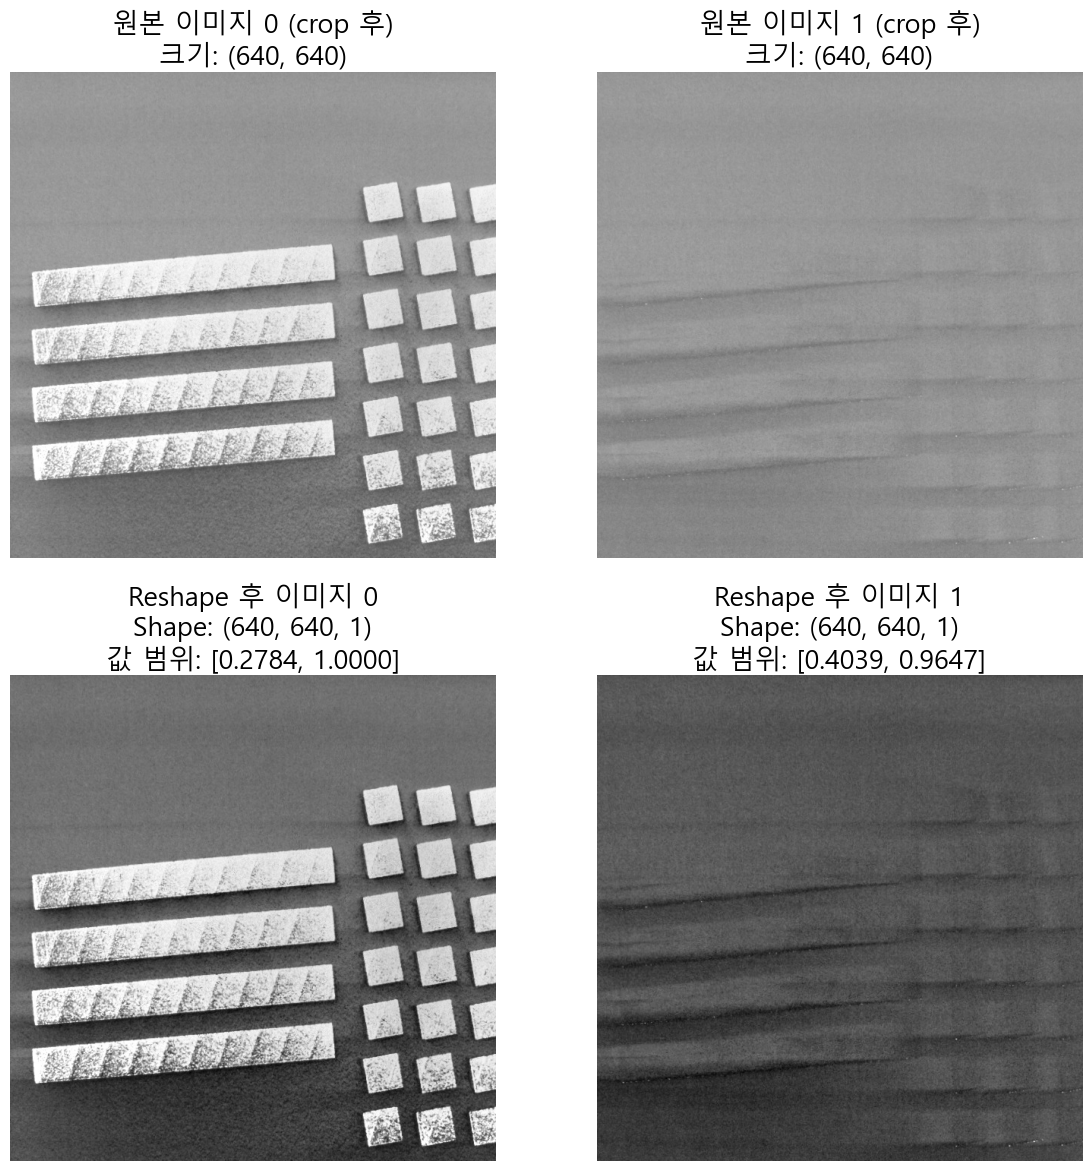


Reshape 후 상세 정보:
imtensor0 shape: (640, 640, 1)
imtensor1 shape: (640, 640, 1)
imtensor0 dtype: <dtype: 'float32'>
imtensor0 값 범위: [0.2784, 1.0000]
imtensor1 값 범위: [0.4039, 0.9647]
imtensor0 평균: 0.6239
imtensor1 평균: 0.5749


In [15]:
# Reshape 이후 이미지 출력
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows에서 한글 지원 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 첫 번째 파일로 테스트
test_file = '000001'
im0 = Image.open(imagePath0 + test_file + '.jpg')
im1 = Image.open(imagePath1 + test_file + '.jpg')
segmentationMask = np.load(npyPath + test_file + '.npy')

# 전처리 과정
tileSize = 128
rightcrop = im0.size[0]//tileSize * tileSize
bottomcrop = im0.size[1]//tileSize * tileSize
im0_cropped = im0.crop((0,0,rightcrop,bottomcrop))
im1_cropped = im1.crop((0,0,rightcrop,bottomcrop))
imarray0 = np.array(im0_cropped)
imarray1 = np.array(im1_cropped)

# RGB to Grayscale 변환
if len(imarray0.shape) == 3 and imarray0.shape[2] == 3:
    imarray0 = np.mean(imarray0, axis=2, keepdims=True)
elif len(imarray0.shape) == 2:
    imarray0 = np.expand_dims(imarray0, axis=2)

if len(imarray1.shape) == 3 and imarray1.shape[2] == 3:
    imarray1 = np.mean(imarray1, axis=2, keepdims=True)
elif len(imarray1.shape) == 2:
    imarray1 = np.expand_dims(imarray1, axis=2)

# Reshape 후
imtensor0 = tf.cast(imarray0.reshape(rightcrop, bottomcrop, 1), tf.float32)/255.0
imtensor1 = tf.cast(imarray1.reshape(rightcrop, bottomcrop, 1), tf.float32)/255.0

# 이미지 출력
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 원본 이미지 (crop 후)
axes[0, 0].imshow(im0_cropped)
axes[0, 0].set_title(f'원본 이미지 0 (crop 후)\n크기: {im0_cropped.size}')
axes[0, 0].axis('off')

axes[0, 1].imshow(im1_cropped)
axes[0, 1].set_title(f'원본 이미지 1 (crop 후)\n크기: {im1_cropped.size}')
axes[0, 1].axis('off')

# Reshape 후 이미지 (그레이스케일)
axes[1, 0].imshow(imtensor0[:, :, 0].numpy(), cmap='gray')
axes[1, 0].set_title(f'Reshape 후 이미지 0\nShape: {imtensor0.shape}\n값 범위: [{tf.reduce_min(imtensor0):.4f}, {tf.reduce_max(imtensor0):.4f}]')
axes[1, 0].axis('off')

axes[1, 1].imshow(imtensor1[:, :, 0].numpy(), cmap='gray')
axes[1, 1].set_title(f'Reshape 후 이미지 1\nShape: {imtensor1.shape}\n값 범위: [{tf.reduce_min(imtensor1):.4f}, {tf.reduce_max(imtensor1):.4f}]')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 추가 정보 출력
print("\n" + "="*60)
print("Reshape 후 상세 정보:")
print(f"imtensor0 shape: {imtensor0.shape}")
print(f"imtensor1 shape: {imtensor1.shape}")
print(f"imtensor0 dtype: {imtensor0.dtype}")
print(f"imtensor0 값 범위: [{tf.reduce_min(imtensor0):.4f}, {tf.reduce_max(imtensor0):.4f}]")
print(f"imtensor1 값 범위: [{tf.reduce_min(imtensor1):.4f}, {tf.reduce_max(imtensor1):.4f}]")
print(f"imtensor0 평균: {tf.reduce_mean(imtensor0):.4f}")
print(f"imtensor1 평균: {tf.reduce_mean(imtensor1):.4f}")
print("="*60)

In [16]:
trainClients = ['client1', 'client2', 'client3', 'client4', 
                'client5']
testClients = ['client6']

clientIDs, NCLIENTS = trainClients, len(trainClients)

Client Data is stored in two separate dictionaries, one for tiled image tensors (X) and other for segmentation masks (Y). Both dictionaries are keyed by `clientID`.

Training Dictionaries - `imageDict`(X) and `segMaskDict`(Y)

Testing Dictionaries - `imageDictTest`(X) and `segMaskDictTest`(Y)

In [17]:
# Train Data (lazy loading 방식)
imageDict, segMaskDict = {}, {}
for clientID in trainClients:
    imageDict[clientID] = datasetImageDict[clientID]
    # lazy loading에서는 segMaskDict에 데이터셋 크기를 저장
    segMaskDict[clientID] = datasetSizeDict[clientID]

# Test Data는 여전히 미리 로드 (평가용이므로)
from utils.u_net.dataset_functions import create_dataset, unwrap_client_data

testClientDict = {clientID: clientIdentifierDict[clientID] for clientID in testClients}
testImageDict, testMaskDict = create_dataset(testClientDict, 
                                             imagePath0, imagePath1, npyPath, 
                                             tileSize = 128)

imageDictTest, segMaskDictTest = {}, {}
for clientID in testClients:
    imageDictTest[clientID] = testImageDict[clientID]
    segMaskDictTest[clientID] = testMaskDict[clientID]

# unwrap test data from dictionary for easier model evaluation
testImages, testMasks = unwrap_client_data(imageDictTest, segMaskDictTest, testClients)


client6...
  처리 중: 13/13 파일 완료 (현재 타일 수: 325)
Contains 13 images...
Tiled Image Tensor Shape:  (325, 128, 128, 2)
Tiled Mask Shape:  (325, 128, 128)


In [18]:
# Set hyperparameters for FL
# For demonstration, we use only 2 server rounds with 5 local epochs
SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE, LOCAL_LEARNING_RATE = 3, 3, 32, 8e-05

# Initialize the global model
model = initialize_unet()

Model: "u-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │        608 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 256) │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 4, 4, 512) │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 8, 8, 512) │          0 │ max_pooling2d_9[… │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8, 512) │    262,656 │ up_sampling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 8, 8,      │          0 │ conv2d_21[0][0],  │
│ (Concatenate)       │ 1024)             │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 512) │  4,719,104 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 16, 16,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │    131,328 │ up_sampling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 16, 16,    │          0 │ conv2d_23[0][0],

 Total params: 8,291,907 (31.63 MB)

 Trainable params: 8,291,907 (31.63 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Run (simulate) FL
# Please use GPU/Colab to avoid very long training time
# https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index
# https://colab.research.google.com/notebooks/gpu.ipynb

model, serverWeights, lossDict, testLoss, accuracyDict, testAccuracy = federated_averaging(model,
                        SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE,
                        LOCAL_LEARNING_RATE,
                        clientIDs, imageDict, segMaskDict,
                        testImages, testMasks)

------ Server Epoch 0 ------
Running local updates for client1...
Epoch 1/3
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 845ms/step - accuracy: 0.7154 - loss: 0.9774
Epoch 2/3


d:\iot\IoT_FL_AM\venv311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


KeyboardInterrupt: 

In [ ]:
# 학습 완료된 모델 저장
import os
from datetime import datetime

# saved_models 폴더가 없으면 생성
os.makedirs('saved_models', exist_ok=True)

# 파일명 생성: FL_ServerRounds_LocalEpochs_BatchSize_LearningRate_TestSet.h5
# 예: FL_2_5_32_8e05_HoldoutPart06.h5
test_set_name = ''.join([c.replace('client', '') for c in testClients])  # '6'
if len(test_set_name) == 1:
    test_set_name = '0' + test_set_name  # '06'

# Learning rate를 문자열로 변환 (8e-05 -> 8e05)
lr_str = f"{LOCAL_LEARNING_RATE:.0e}".replace('-', '').replace('+', '').replace('.0', '')

# 기본 파일명 생성
base_filename = f'saved_models/FL_{SERVER_ROUNDS}_{LOCAL_EPOCHS}_{LOCAL_BATCH_SIZE}_{lr_str}_HoldoutPart{test_set_name}.h5'

# 파일이 이미 존재하는지 확인하고, 존재하면 번호를 추가
model_filename = base_filename
counter = 1
while os.path.exists(model_filename):
    # 파일명에서 확장자 분리
    base_name, ext = os.path.splitext(base_filename)
    # 번호 추가: FL_2_5_32_8e05_HoldoutPart06_1.h5
    model_filename = f'{base_name}_{counter}{ext}'
    counter += 1

# 모델 저장
print(f'모델 저장 중: {model_filename}')
model.save(model_filename)
print(f'모델 저장 완료!')

# 최종 테스트 성능 출력
print(f'\n최종 테스트 성능:')
print(f'  Loss: {testLoss[-1]:.4f}')
print(f'  Accuracy: {testAccuracy[-1]:.4f}')

For client6...
000066
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
MeanIoU= 0.641


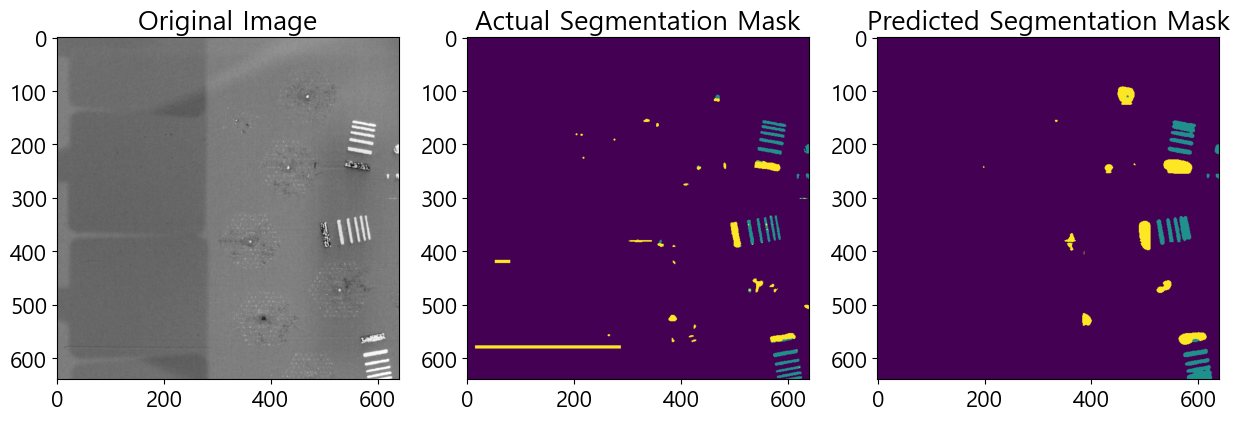

000067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
MeanIoU= 0.628


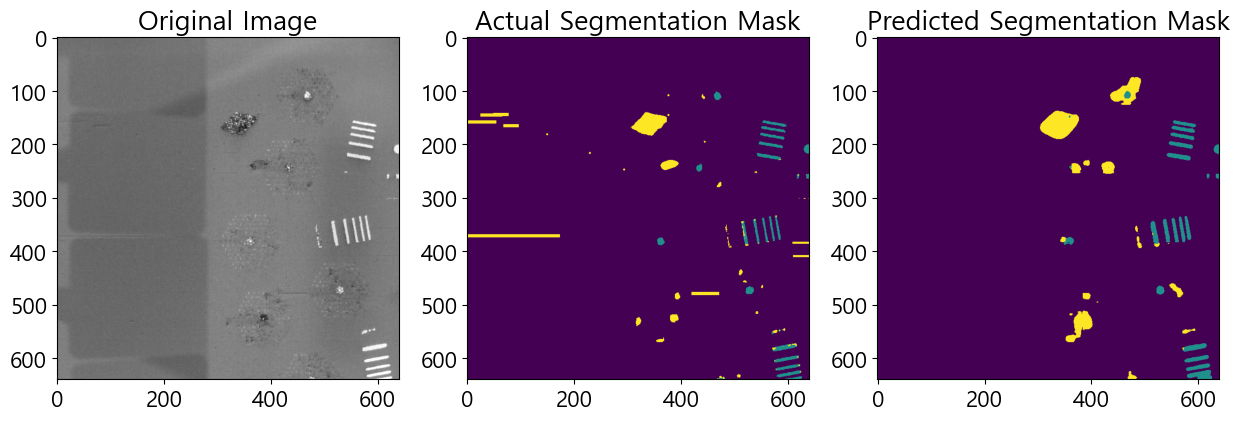

000068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
MeanIoU= 0.614


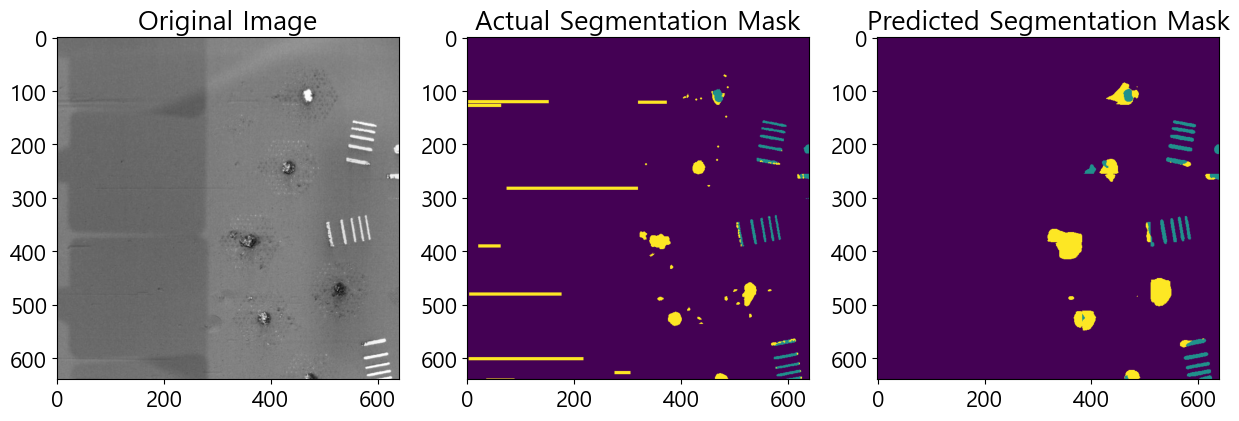

000069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
MeanIoU= 0.575


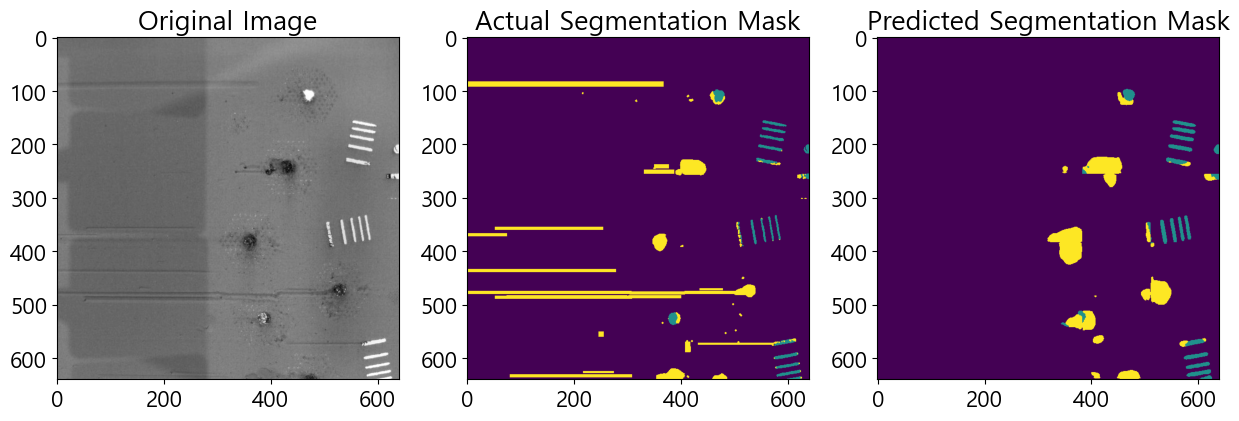

000070
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
MeanIoU= 0.583


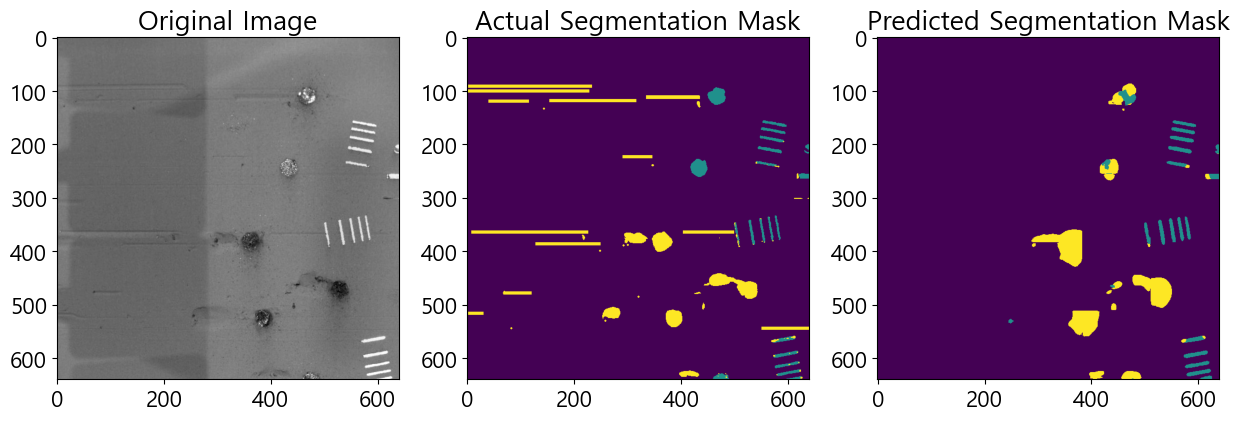

000071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
MeanIoU= 0.537


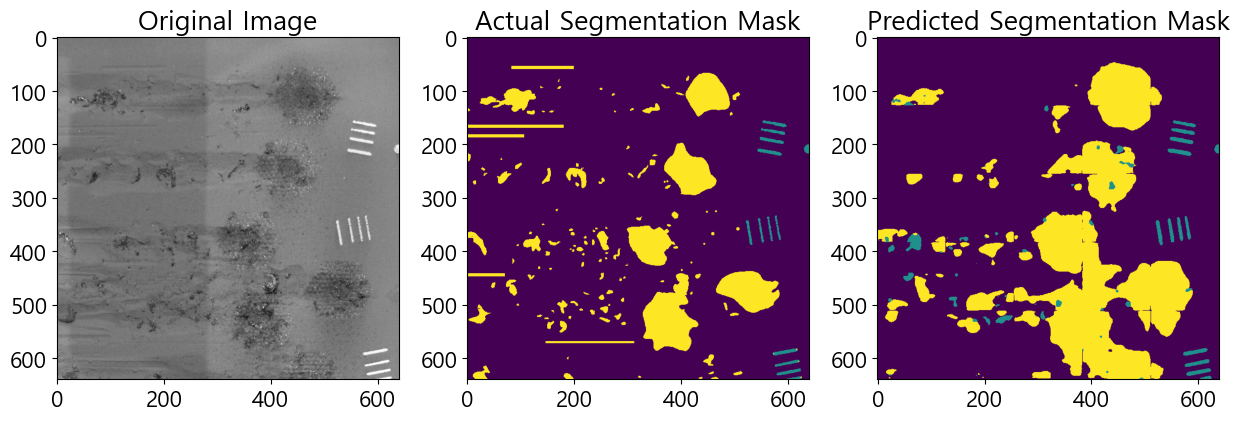

000072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
MeanIoU= 0.507


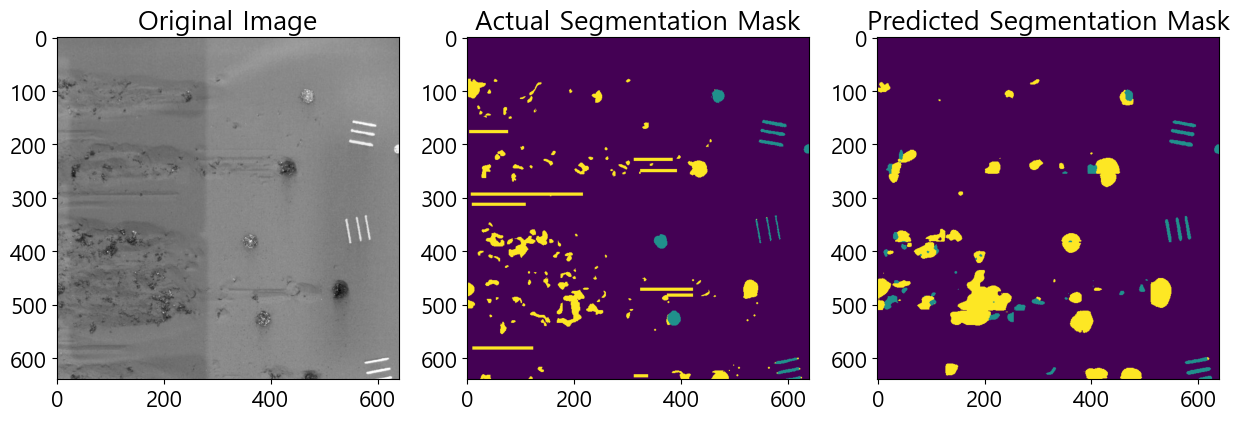

000073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
MeanIoU= 0.596


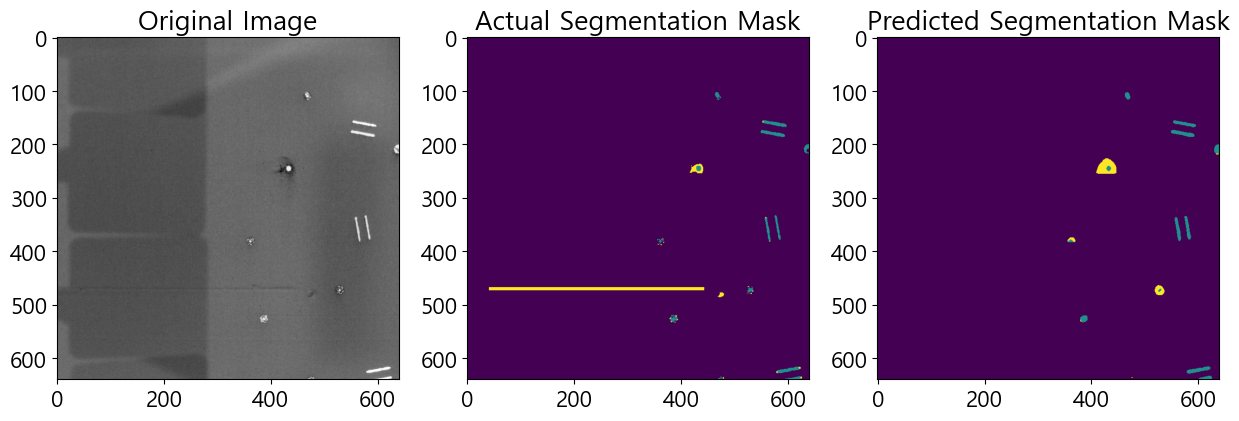

000074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
MeanIoU= 0.656


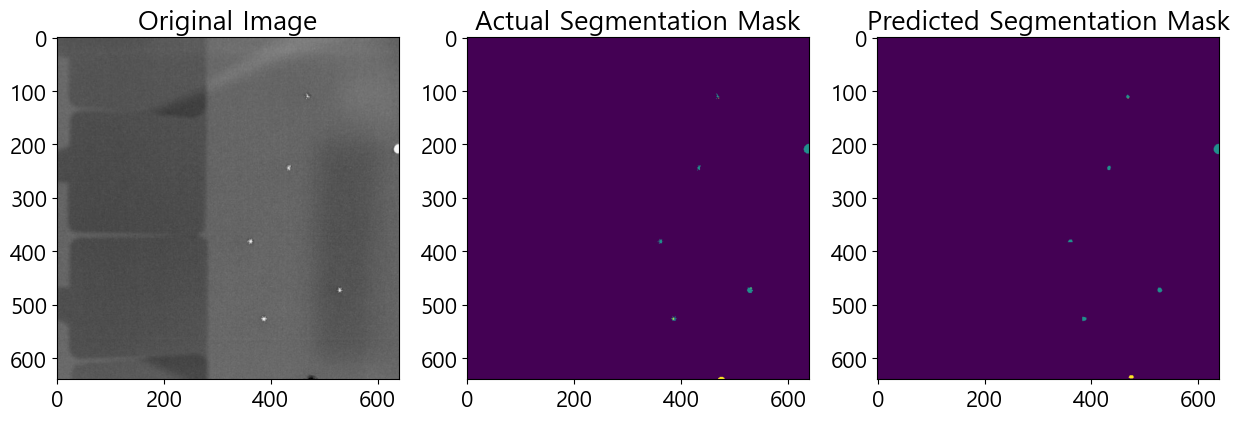

000075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
MeanIoU= 0.56


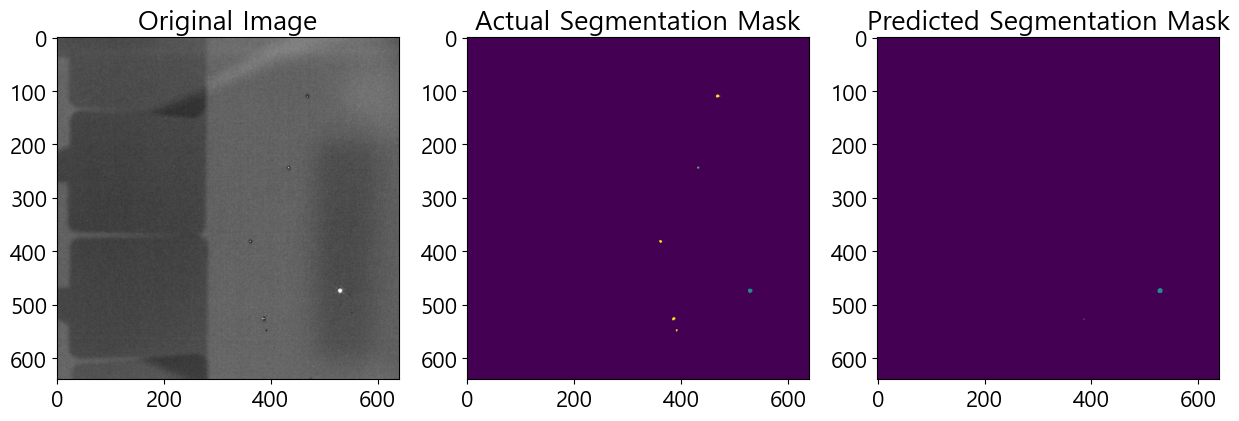

000076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
MeanIoU= 0.491


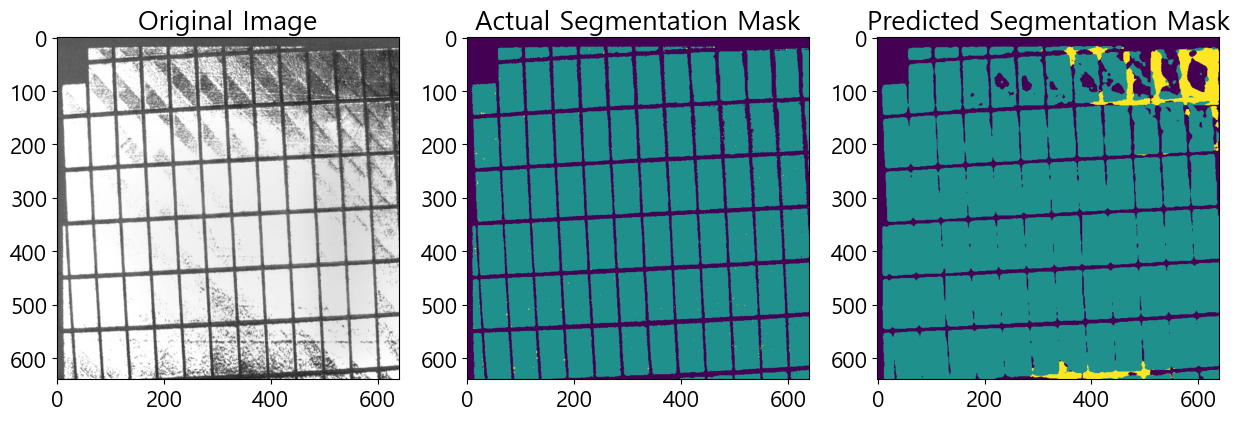

000077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
MeanIoU= 0.415


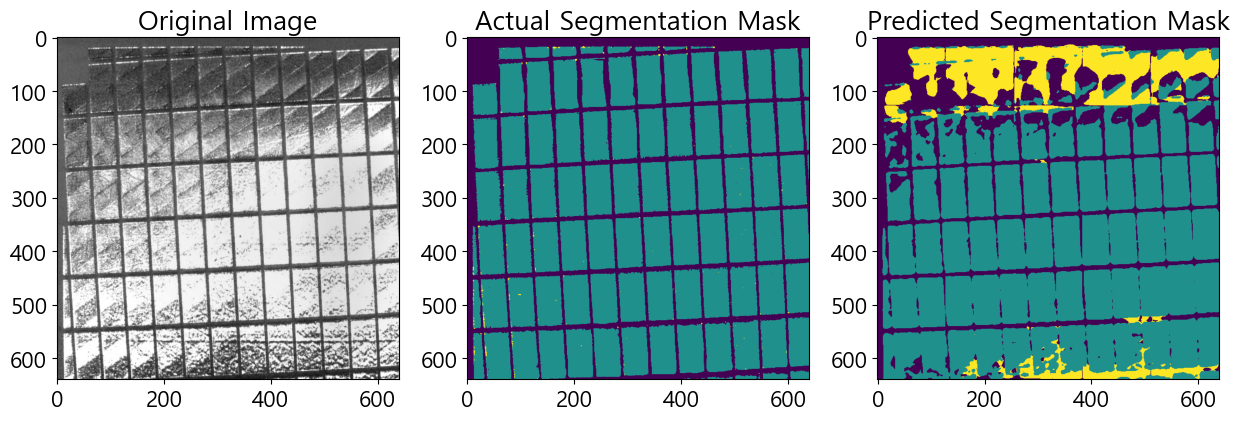

000078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
MeanIoU= 0.501


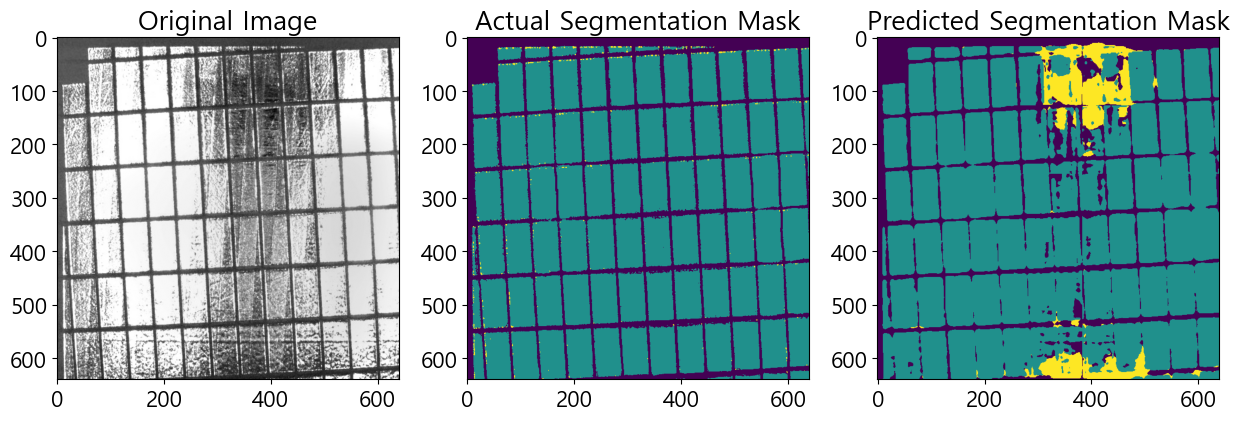

In [23]:
fl_model = tf.keras.models.load_model('saved_models/FL_2_5_32_8e05_HoldoutPart06_1.h5', compile=False)

visualize_results_testset(fl_model, imageDictTest, segMaskDictTest,
                              testClients, clientIdentifierDict)